<a href="https://colab.research.google.com/github/barbaramit/jogando-os-dados/blob/main/PS_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESAFIO: AVALIAÇÃO DE VENDAS DE UMA LOJA E-COMMERCE 



Em um mercado competitivo, as empresas precisam saber como utilizar seus dados para uma proposta melhor de vendas. A análise de dados possibilita transformar grandes conjuntos de dados em informações claras, a elaborar estratégias mais assertivas e eficazes para vender mais e a orientar as tomadas de decisão da empresa.

Diante desse cenário, o Desafio proposto tem como escopo auxiliar o monitoramento de uma loja de e-commerce brasileira, na tarefa de acompanhar o crescimento de receita da loja e a experiência do cliente.

#  1. Características do Modelo de Dados

O modelo de dados disponibilizado abaixo, contém o histórico de vendas concedido com a informação de produtos e lojas relacionadas aos clientes.



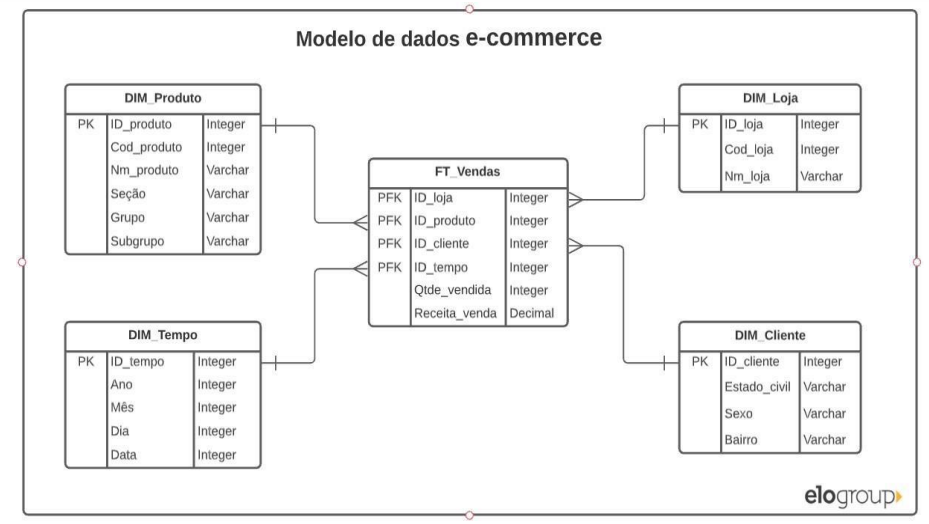

O modelo apresentado é do tipo dimensional "Star schema", ou seja, os dados
são modelados em tabelas dimensionais ligadas a uma tabela de fatos via chaves estrangeiras (FK e PFK). Nesse caso, FT_Vendas é a nossa "Fact Table" e as demais são as "Dimension Tables".

A FT_Vendas possui 4 chaves primárias estrangeiras, responsáveis por ligar as Dimension Tables com a Fact Table. Essas 4 chaves PFK juntas representam uma única PK da tabela FT_Vendas, tendo a restrição de ser "unique". Ou seja, essas combinações de PFK podem identificar exclusivamente cada registro na tabela de fatos.

Esse tipo de modelagem de dados é facilmente interpretada, pois a informação
está agrupada em simples e claras categorias (tabelas e atributos) referentes
ao tipo de negócio, que nesse caso é o e-commerce. Modelos dimensionais, por não serem normalizados, são otimizados para alto desempenho e para consulta rápida de dados, apesar da necessidade de storage ser superior também.

A partir dos atributos já presentes nesse modelo e com as informações dadas,
podemos verificar os produtos mais vendidos, faturamento total/por produto/por loja/anual, evolução das vendas por período e sazonalidade, entre outros. Logo, apenas com os atributos existentes já podemos analisar os dados e transformá-los em informações claras e em indicadores, o que ajudará a acompanhar o crescimento de receita da loja e a experiência do cliente. 

Entretanto, o modelo não nos permite analisar, por exemplo, a distribuição
regional das vendas e o perfil do cliente apenas com o Bairro, Sexo e
Estado_civil. Logo, não temos atributos suficientes na tabela DIM_Cliente para
esse tipo de análise. Na tabela DIM_Produto não há informações sobre o preço unitário do produto e, dependendo do tipo de e-commerce, atributos como tamanho, cor, quantidade mínima ou valor mínimo são necessários. Não temos informações sobre a entrega do pedido, o meio de pagamento e se a venda teve algum desconto ou promoção. 

O Star schema não é um modelo adequado para tabelas com relacionamento M-N. Por conta disso e por não termos uma chave PK única para a tabela FT_Vendas, não conseguimos identificar tão facilmente compras com mais de um produto, por exemplo. 

Além disso, na tabela DIM_Tempo, o atributo Data está indicado como tipo INTEGER, o que atrapalha nas análises temporais e, ao analisarmos o arquivo da tabela, como ele está no formato DD/MM/YYYY não é nem possível inseri-lo como INT. O mesmo ocorre na FT_Vendas com o atributo Receita_venda que está com o símbolo $.

Ainda analisando o arquivo da tabela `Tempo`, notamos que não existe uma padronização das chaves (codigos), ou seja, **cada data não possui um código único**. O mesmo ocorre na tabela `Produto`.  



# 2. Consultas

Inicializando banco de dados

In [1]:
import io
import sqlite3
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importando os arquivos em csv

In [2]:
dataVendas = pd.read_csv (r'/content/drive/MyDrive/EG/vendas.csv',sep=';')   
dataTempo = pd.read_csv (r'/content/drive/MyDrive/EG/DIM_Tempo.csv',sep=';',encoding='latin-1')   
dataProduto = pd.read_csv (r'/content/drive/MyDrive/EG/DIM_Produto.csv',sep=';',encoding='latin-1')   
dataLoja = pd.read_csv (r'/content/drive/MyDrive/EG/DIM_Loja.csv',sep=';',encoding='latin-1')   
dataCliente = pd.read_csv (r'/content/drive/MyDrive/EG/cliente.csv',sep=';',encoding='latin-1', skipinitialspace=True)

dataCliente.rename(columns={"ID_Cliente ": "ID_Cliente", "Estado Civil": "Estado_civil"},inplace=True) # corrigindo erro ao importar


Criando banco no SQLite

In [3]:
conn = sqlite3.connect('databasePSElo.db')
c = conn.cursor()

c.execute('''CREATE TABLE DIM_Tempo (ID_Tempo int NOT NULL,Ano int NOT NULL,Mês int NOT NULL,Dia int NOT NULL,Data int NOT NULL, PRIMARY KEY(ID_Tempo))''')
dataTempo.to_sql('DIM_Tempo', conn, if_exists='append', index = False)

c.execute('''CREATE TABLE DIM_Produto (ID_Produto int NOT NULL,COD_Produto int NOT NULL,NM_Produto text NOT NULL,
              Secao text,Grupo text,Subgrupo text, PRIMARY KEY(ID_Produto))''')
dataProduto.to_sql('DIM_Produto', conn, if_exists='append', index = False)

c.execute('''CREATE TABLE DIM_Loja (ID_Loja int NOT NULL, COD_Loja int NOT NULL, NM_Loja text NOT NULL, PRIMARY KEY(ID_Loja))''')
dataLoja.to_sql('DIM_Loja', conn, if_exists='append', index = False)

c.execute('''CREATE TABLE DIM_Cliente (ID_Cliente int NOT NULL, Estado_civil text, Sexo text, Bairro text, PRIMARY KEY(ID_Cliente))''')
dataCliente.to_sql('DIM_Cliente', conn, if_exists='append', index = False)

c.execute('''CREATE TABLE FT_Vendas (ID_Loja int NOT NULL,ID_Produto int NOT NULL,ID_Cliente int NOT NULL,
          ID_Tempo int NOT NULL,Qtde_Vendida int NOT NULL,Receita_venda real NOT NULL, PRIMARY KEY(ID_Loja,ID_Produto,ID_Cliente,ID_Tempo),
          FOREIGN KEY (ID_Loja) REFERENCES DIM_Loja(ID_Loja), FOREIGN KEY (ID_Produto) REFERENCES DIM_Produto(ID_Produto), 
          FOREIGN KEY (ID_Cliente) REFERENCES DIM_Cliente(ID_Cliente),FOREIGN KEY (ID_Tempo) REFERENCES DIM_Tempo(ID_Tempo))''')
dataVendas.to_sql('FT_Vendas', conn, if_exists='append', index = False)

20

### 2.1: Quantidade vendida no período entre 01/04/2020 a 01/04/2021

---



No SQLite não há o tipo de atributo DATE, somente é necessário que as datas estejam no formato YYYY-MM-DD para realizar operações. 
Também não há uma função direta para transformar de um tipo em outro como em outros bancos. Ex no MYSQL: ``(DATE_FORMAT(STR_TO_DATE(CAST(T.Data AS varchar(50)), '%d/%m/%Y'), '%Y-%m-%d'))``


In [7]:
query = """
SELECT sum(V.Qtde_Vendida)
FROM FT_Vendas as V
INNER JOIN DIM_Tempo as T ON V.ID_Tempo = T.ID_Tempo
WHERE DATE(substr(T.Data,7,4)||'-'||substr(T.Data,4,2)||'-'||substr(T.Data,1,2)) BETWEEN DATE('2020-04-01') AND DATE('2021-04-01')
"""
start = timer()
df = pd.read_sql_query(query, conn)
end = timer()
print("Tempo de execução: ", end - start)
#CAST(strftime('%s', T.Data)  AS  integer) strftime(CAST(T.Data as text),'%d-%m-%Y')

df

 


Tempo de execução:  0.0032327059999488483


,sum(V.Qtde_Vendida)
0,8979


### 2.2 Quantidade de clientes únicos do sexo feminino e estado civil divorciada

In [9]:
query = """
SELECT count(DISTINCT C.ID_Cliente)
FROM DIM_Cliente as C
WHERE C.Sexo = 'Feminino' AND C.Estado_civil = 'Separado'
"""

start = timer()
df = pd.read_sql_query(query, conn)
end = timer()
print("Tempo de execução: ", end - start)
df

Tempo de execução:  0.0050333389999650535


,count(DISTINCT C.ID_Cliente)
0,3


In [16]:
query = """
SELECT *
from FT_Vendas as V 
INNER JOIN DIM_Produto as P ON V.ID_Produto = P.ID_Produto 
INNER JOIN DIM_Loja as L ON V.ID_Loja = L.ID_Loja
"""

start = timer()
df = pd.read_sql_query(query, conn)
end = timer()
print("Tempo de execução: ", end - start)
df

Tempo de execução:  0.003968609000366996


,ID_Loja,ID_Produto,ID_Cliente,ID_Tempo,Qtde_Vendida,Receita_venda,ID_Produto,COD_Produto,NM_Produto,Secao,Grupo,Subgrupo,ID_Loja,COD_Loja,NM_Loja
0,1,1,1,18,4803,$610.92,1,120,Monitor,Eletronico,Tecnologia,Informatica,1,21,Flor de Liz
1,2,17,2,2,722,$504.57,17,120,Notebook,Eletronico,Tecnologia,Informatica,2,33,Magazine Luiza
2,3,3,3,23,1746,$196.75,3,27,Sapato,Vestimenta,Calcados,Sport,3,78,Flor da pele
3,4,4,12,4,981,$250.28,4,98,Modem,Eletronico,Tecnologia,Informatica,4,5,Wallmart
4,5,13,5,5,280,$180.26,13,33,Condicionador,Beleza,Perfumaria,Cabelos Loiros,5,32,Ana July
5,6,6,44,38,3078,$448.26,6,55,Tenis,Vestimenta,Calcados,Corrida,6,456,Animale
6,7,7,7,7,349,$955.57,7,456,Shampoo,Beleza,Perfumaria,Cabelo Lisos,7,234,Victor Hugo
7,8,8,8,8,585,$1493.95,8,234,Caderno,Papelaria,Material Escolar,None,8,367,Reserva
8,9,9,9,9,2024,$1291.00,9,367,Borracha,Papelaria,Material Escolar,None,9,32,Hortensias Moda
9,10,18,10,15,1028,$839.01,18,123,Creme para pele,Beleza,Perfumaria,Diurno,10,1,Elegance Modas


### 2.3 Buscar os produtos com código 55,120,142 e que tiveram receita maior que R$120,00; 

In [6]:
query = """
SELECT *
FROM DIM_Produto as P
INNER JOIN FT_Vendas as V ON P.ID_Produto = V.ID_Produto
WHERE P.COD_Produto in (55,120,142) AND CAST(substr(V.Receita_venda,2,6) AS REAL) > 120
"""
#CAST(substr(cast(V.Receita_venda as text),2,6) AS REAL) > 120

start = timer()
df = pd.read_sql_query(query, conn)
end = timer()
print("Tempo de execução: ", end - start)
df

Tempo de execução:  0.006117941000013616


,ID_Produto,COD_Produto,NM_Produto,Secao,Grupo,Subgrupo,ID_Loja,ID_Produto,ID_Cliente,ID_Tempo,Qtde_Vendida,Receita_venda
0,1,120,Monitor,Eletronico,Tecnologia,Informatica,1,1,1,18,4803,$610.92
1,17,120,Notebook,Eletronico,Tecnologia,Informatica,2,17,2,2,722,$504.57
2,6,55,Tenis,Vestimenta,Calcados,Corrida,6,6,44,38,3078,$448.26
3,14,142,Meia,Vestimenta,Meias,Meia longa,14,14,14,14,4271,$527.52
4,20,142,Jaqueta,Vestimenta,Roupas,Couro,20,20,28,20,234,$961.01


### 2.4 Verificar a receita da loja com o código 32 no período igual ou superior a 01/04/2021; 

In [28]:
query = """
SELECT sum(V.Receita_venda)
FROM FT_Vendas as V
INNER JOIN DIM_Loja as L, DIM_Tempo as T ON V.ID_Loja = L.ID_Loja AND V.ID_Tempo = T.ID_Tempo
WHERE COD_Loja = 32 AND DATE(substr(T.Data,7,4)||'-'||substr(T.Data,4,2)||'-'||substr(T.Data,1,2)) >= '2021-04-01'
"""

start = timer()
df = pd.read_sql_query(query, conn)
end = timer()
print("Tempo de execução: ", end - start)
df

Tempo de execução:  0.008012131998839322


,ID_Loja,ID_Produto,ID_Cliente,ID_Tempo,Qtde_Vendida,Receita_venda,ID_Loja,COD_Loja,NM_Loja,ID_Tempo,Ano,Mês,Dia,Data
0,5,13,5,5,280,$180.26,5,32,Ana July,5,2022,1,8,08/01/2022


In [45]:
query = """
SELECT *
FROM FT_Vendas as V
INNER JOIN DIM_Loja as L, DIM_Tempo as T ON V.ID_Loja = L.ID_Loja AND V.ID_Tempo = T.ID_Tempo
WHERE COD_Loja = 32 AND (substr(T.Data,7,4)||'-'||substr(T.Data,4,2)||'-'||substr(T.Data,1,2)) >= '2021-04-01'
"""

start = timer()
df = pd.read_sql_query(query, conn)
end = timer()
print("Tempo de execução: ", end - start)
df

Tempo de execução:  0.004919691000395687


,ID_Loja,ID_Produto,ID_Cliente,ID_Tempo,Qtde_Vendida,Receita_venda,ID_Loja,COD_Loja,NM_Loja,ID_Tempo,Ano,Mês,Dia,Data
0,5,13,5,5,280,$180.26,5,32,Ana July,5,2022,1,8,08/01/2022


# 3. Melhorias

Normalizar

Criar ID para Vendas

Criar Tabela Vendas e Produto 

Criar Tabela Categorias

Pensando em análises: add novos atributos, criar nova tabela